# Loan Default Prediction

SuperLender is a local digital lending company, which prides itself in its effective use of credit risk models to deliver profitable and high-impact loan alternative. Its assessment approach is based on two main risk drivers of loan default prediction:.
- 1) willingness to pay and 
- 2) ability to pay. Since not all customers pay back, the company invests in experienced data scientist to build robust models to effectively predict the odds of repayment.

These two fundamental drivers need to be determined at the point of each application to allow the credit grantor to make a calculated decision based on repayment odds, which in turn determines if an applicant should get a loan, and if so - what the size, price and tenure of the offer will be.

There are two types of risk models in general: New business risk, which would be used to assess the risk of application(s) associated with the first loan that he/she applies. The second is a repeat or behaviour risk model, in which case the customer has been a client and applies for a repeat loan. In the latter case - we will have additional performance on how he/she repaid their prior loans, which we can incorporate into our risk model.

It is your job to predict if a loan was good or bad, i.e. accurately predict binary outcome variable, where Good is 1 and Bad is 0.


### 1.2 Description of the data

There are 3 different datasets for both train and test

#### 1.2.1 Demographic data (traindemographics.csv)
- customerid (Primary key used to merge to other data)
- birthdate (date of birth of the customer)
- bank_account_type (type of primary bank account)
- longitude_gps
- latitude_gps
- bank_name_clients (name of the bank)
- bank_branch_clients (location of the branch - not compulsory - so missing in a lot of the cases)
- employment_status_clients (type of employment that customer has)
- level_of_education_clients (highest level of education)

#### 1.2.2 Performance data (trainperf.csv) : 
This is the repeat loan that the customer has taken for which we need to predict the performance of. Basically, we need to predict if whether this loan would default given all previous loans and demographics of a customer.
- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Loan value taken)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
- termdays (Term of loan)
- referredby (customerId of the customer that referred this person - is missing, then not referred)
- good_bad_flag (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predic

#### 1.2.3 Previous loans data (trainprevloans.csv) : 
This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of. Each loan will have a different systemloanid, but the same customerid for each customer.

- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Date that loan application was created)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees) termdays (Term of loan)
- closeddate (Date that the loan was settled)
- referredby (customerId of the customer that referred this person - is missing, then not refrerred)
- firstduedate (Date of first payment due in cases where the term is longer than 30 days. So in the case where the term is 60+ days - then there are multiple monthly payments due - and this dates reflects the date of the first payment)
- firstrepaiddate (Actual date that he/she paid the first payment as defined above)



### Loading Libraries and Data

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from math import ceil

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 
plt.rcParams['figure.figsize'] = (16, 6)

### demographics data

In [2]:
demo_data_train = pd.read_csv('demographics.csv')
demo_data_test = pd.read_csv('testdemographics.csv')
demo_data = pd.concat([demo_data_train,demo_data_test])
demo_data.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


In [3]:
demo_data.duplicated().sum()

15

In [4]:
demo_data.drop_duplicates(inplace=True)

In [5]:
demo_data.shape

(5818, 9)

### performance data

In [6]:
perf_data = pd.read_csv('perf.csv')
perf_data.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


In [7]:
perf_data.shape

(4368, 10)

### prevloans data

In [8]:
ploan_data_train = pd.read_csv('prevloans.csv')
ploan_data_test = pd.read_csv('testprevloans.csv')
ploan_data = pd.concat([ploan_data_train,ploan_data_test])
ploan_data.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [9]:
ploan_data.isnull().sum()

customerid             0
systemloanid           0
loannumber             0
approveddate           0
creationdate           0
loanamount             0
totaldue               0
termdays               0
closeddate             0
referredby         22739
firstduedate           0
firstrepaiddate        0
dtype: int64

In [10]:
ploan_data.shape

(24090, 12)

In [11]:
ploan_data.duplicated().sum()

0

**Joining performance and demographics data**

In [12]:
data = perf_data.merge(demo_data, how='left', on='customerid', copy=False)
data.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good,1985-08-23 00:00:00.000000,Savings,3.885298,7.320700,GT Bank,"DUGBE,IBADAN",Permanent,Graduate
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good,1984-09-18 00:00:00.000000,Other,11.139350,10.292041,EcoBank,NaN,Permanent,NaN
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good,1977-10-10 00:00:00.000000,Savings,3.985770,7.491708,First Bank,NaN,Permanent,NaN
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good,1986-09-07 00:00:00.000000,Other,7.457913,9.076574,GT Bank,NaN,Permanent,Primary


In [13]:
data.shape

(4368, 18)

**Checking Null Values**

In [14]:
data.isnull().sum()

customerid                       0
systemloanid                     0
loannumber                       0
approveddate                     0
creationdate                     0
loanamount                       0
totaldue                         0
termdays                         0
referredby                    3781
good_bad_flag                    0
birthdate                        0
bank_account_type                0
longitude_gps                    0
latitude_gps                     0
bank_name_clients                0
bank_branch_clients           4325
employment_status_clients      657
level_of_education_clients    3763
dtype: int64

* Most of the variables have null values.
* Might need to look at the percentages of null values.

**Percentage of Null Values**

In [15]:
round(data.isnull().sum()/data.shape[0]*100,2)

customerid                     0.00
systemloanid                   0.00
loannumber                     0.00
approveddate                   0.00
creationdate                   0.00
loanamount                     0.00
totaldue                       0.00
termdays                       0.00
referredby                    86.56
good_bad_flag                  0.00
birthdate                      0.00
bank_account_type              0.00
longitude_gps                  0.00
latitude_gps                   0.00
bank_name_clients              0.00
bank_branch_clients           99.02
employment_status_clients     15.04
level_of_education_clients    86.15
dtype: float64

**Datatypes of variables**

In [16]:
data.dtypes

customerid                     object
systemloanid                    int64
loannumber                      int64
approveddate                   object
creationdate                   object
loanamount                    float64
totaldue                      float64
termdays                        int64
referredby                     object
good_bad_flag                  object
birthdate                      object
bank_account_type              object
longitude_gps                 float64
latitude_gps                  float64
bank_name_clients              object
bank_branch_clients            object
employment_status_clients      object
level_of_education_clients     object
dtype: object

## Univariate Analysis 

**customerid**

In [17]:
#Unique values in customerid
data['customerid'].nunique()

4368

customerid is the unique id given to each indivual customer. So there is not anything to analyse in this column and we can drop it for the modeling part.

**systemloanid**

In [18]:
#Unique values in systemloanid
data['systemloanid'].nunique()

4368

Again, for the systemloanid the number of unique values is exactly similar to the number of rows. We can't use this for our modeling.

**loannumber**

In [19]:
#Unique values in loan number
data['loannumber'].nunique()

23

In [20]:
def Bar_plot(data, column, rotation=0):
    plt.figure(figsize=(16,6))
    g = sns.countplot(data[column], palette='Set2')
    for i in g.patches:
            g.annotate(s='{:.0f}'.format(i.get_height()), xy=(i.get_x()+0.2, i.get_height()+1))
    plt.xticks(rotation=rotation)
    plt.title('Count of {}'.format(column))
    plt.tight_layout()

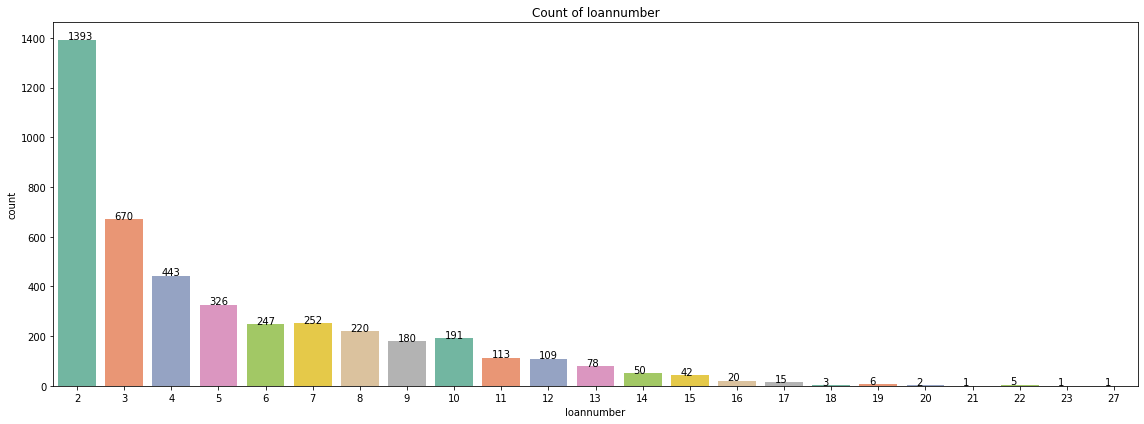

In [21]:
Bar_plot(data, 'loannumber')

**Observations:**
* There is no customer who is applying for loan for the first time. 
* There are few people who are applying for the loan more than 15th times.

**To check:**
People with high number of times loan applied are good customers(paid back loan amount).

**approvedate and creationdate**

In [22]:
# Converting both variables to datetime format 
for i in ['approveddate', 'creationdate']:
    data[i] = pd.to_datetime(data[i])

**Range for approvedate**

In [23]:
min(data['approveddate']), max(data['approveddate'])

(Timestamp('2017-07-01 01:35:26'), Timestamp('2017-07-30 22:55:51'))

* The dates ranges from 01-07-2017 to 30-07-2017
* We have data for only one month.

**Range for creationdate**

In [24]:
min(data['creationdate']), max(data['creationdate'])

(Timestamp('2017-07-01 00:35:20'), Timestamp('2017-07-30 21:55:43'))

* Similar trend as approvedate.

Text(0.5, 0, 'Date')

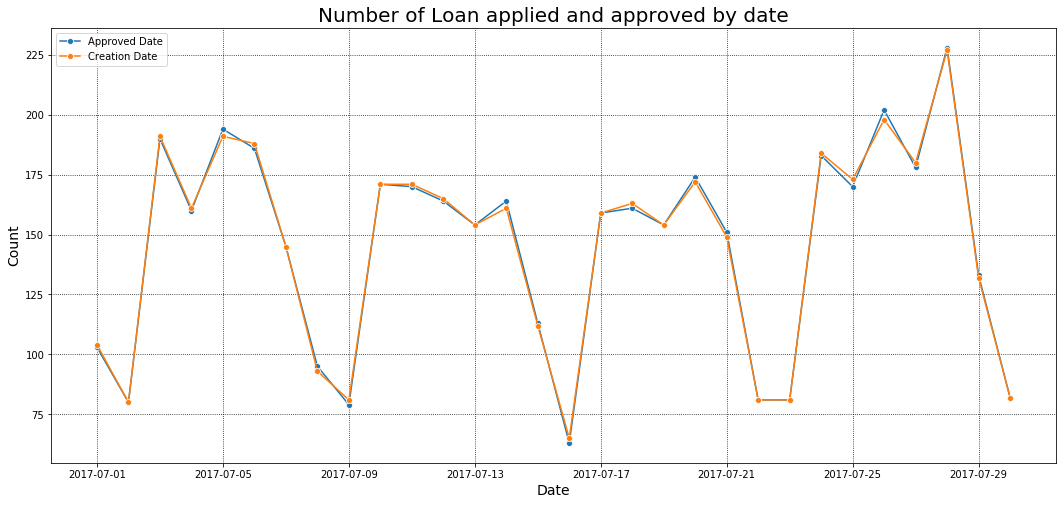

In [25]:
plt.figure(figsize=(18,8))
plt.grid(True, color='k', linestyle=':')
sns.lineplot(x=data['approveddate'].dt.date.value_counts().index, y=data['approveddate'].dt.date.value_counts(), label='Approved Date', marker='o')
sns.lineplot(x=data['creationdate'].dt.date.value_counts().index, y=data['creationdate'].dt.date.value_counts(), label='Creation Date', marker='o')
plt.legend()
plt.title('Number of Loan applied and approved by date', fontsize=20)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Date', fontsize=14)

**Obsevations:**
* Most of the datapoints are overlapping for both creation and approved date, shows most of the loan got approved the same day of request.
* There are some deviation also which signifies, for some applications loan took some time to get approved.
* For different day of weeks we have alot of deviation in number of loan filed and approved.

**Creating new feature approval time**

In [26]:
data['approval_time'] = round(((data['approveddate'] - data['creationdate']).dt.seconds)/3600,2)

**Kdeplot for distribution of approval time**

In [27]:
# function for easy and efficient analysis of numerical variables
def Kde_plot(data, var_group, bw='scott'):
    
    # Specifing the size of the canvas
    size = len(var_group)
    plt.figure(figsize=(16,6) if size == 1 else (16,size*5),dpi=100)
    sns.set(palette="Set2")
    
    # loop for printing/ploting the descriptive statistics of the numerical variables 
    for j,i in enumerate(var_group):
        
        # calculating the descriptive statistics 
        mini = data[i].min()
        maxi = data[i].max()
        ran  = maxi - mini 
        mean = data[i].mean()
        med  = data[i].median()
        st_dev = data[i].std()
        skew = data[i].skew()
        kurt = data[i].kurtosis()
        
        # Calculating the points of standerd daviation 
        points = mean-st_dev, mean+st_dev
        
        # Ploting the variables with every informaton 
        plt.subplot(1 if size==1 else 2,ceil(size/2),j+1)
        sns.kdeplot(data[i],shade=True, bw=bw)
        sns.lineplot(points,[0,0],color='black',label='std_dev')
        sns.scatterplot([mini,maxi],[0,0],color='red',label='min\max')
        sns.scatterplot(mean,[0],color='blue',label='mean')
        sns.scatterplot(med,[0],color='green',label='median')
        plt.xlabel("{}".format(i),fontsize=(14))
        plt.ylabel('density',fontsize=(14))
        plt.tight_layout()
        plt.title('std_dev= {}; kurtosis= {}; skew= {};\nmean= {}; median= {}; range = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                 round(kurt,2),
                                                                                                 round(skew,2),
                                                                                                 round(mean,2),
                                                                                                 round(med,2),
                                                                                                 (round(mini,2),round(maxi,2),round(ran,2))),fontsize=16)
        plt.tight_layout()

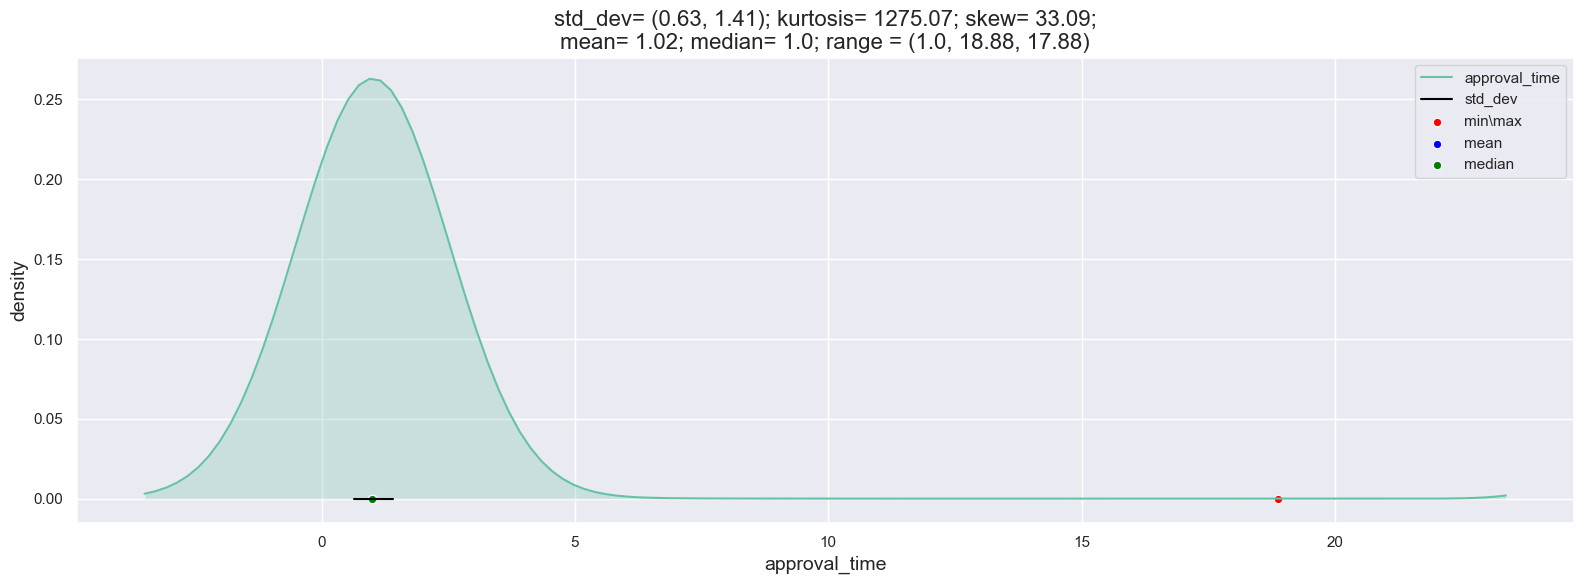

In [28]:
Kde_plot(data, ['approval_time'], bw=1.5)

**Observations:**
* Most of the loans got approved within 1-3 hours.
* There are very few loans that took more than 3 hours to get approved.

**To check:** Deos customers getting more time in approval are defaulters.

In [29]:
data['approval_time'].sort_values(ascending=False)[:10]

1843    18.88
2450    13.02
4130     9.49
2250     7.39
4089     6.43
2510     5.30
2343     5.05
3267     4.05
3348     4.01
1564     3.27
Name: approval_time, dtype: float64

* At max it took 18 hours to get the loan approved.

**Creating new feature creation date day of week**

In [30]:
data['creationdate_dow'] = data['creationdate'].dt.dayofweek

In [31]:
Category_plot('creationdate_dow', data)

NameError: name 'Category_plot' is not defined

* As expected, on weekends least application for loan are applied.

### loan amount and totaldue

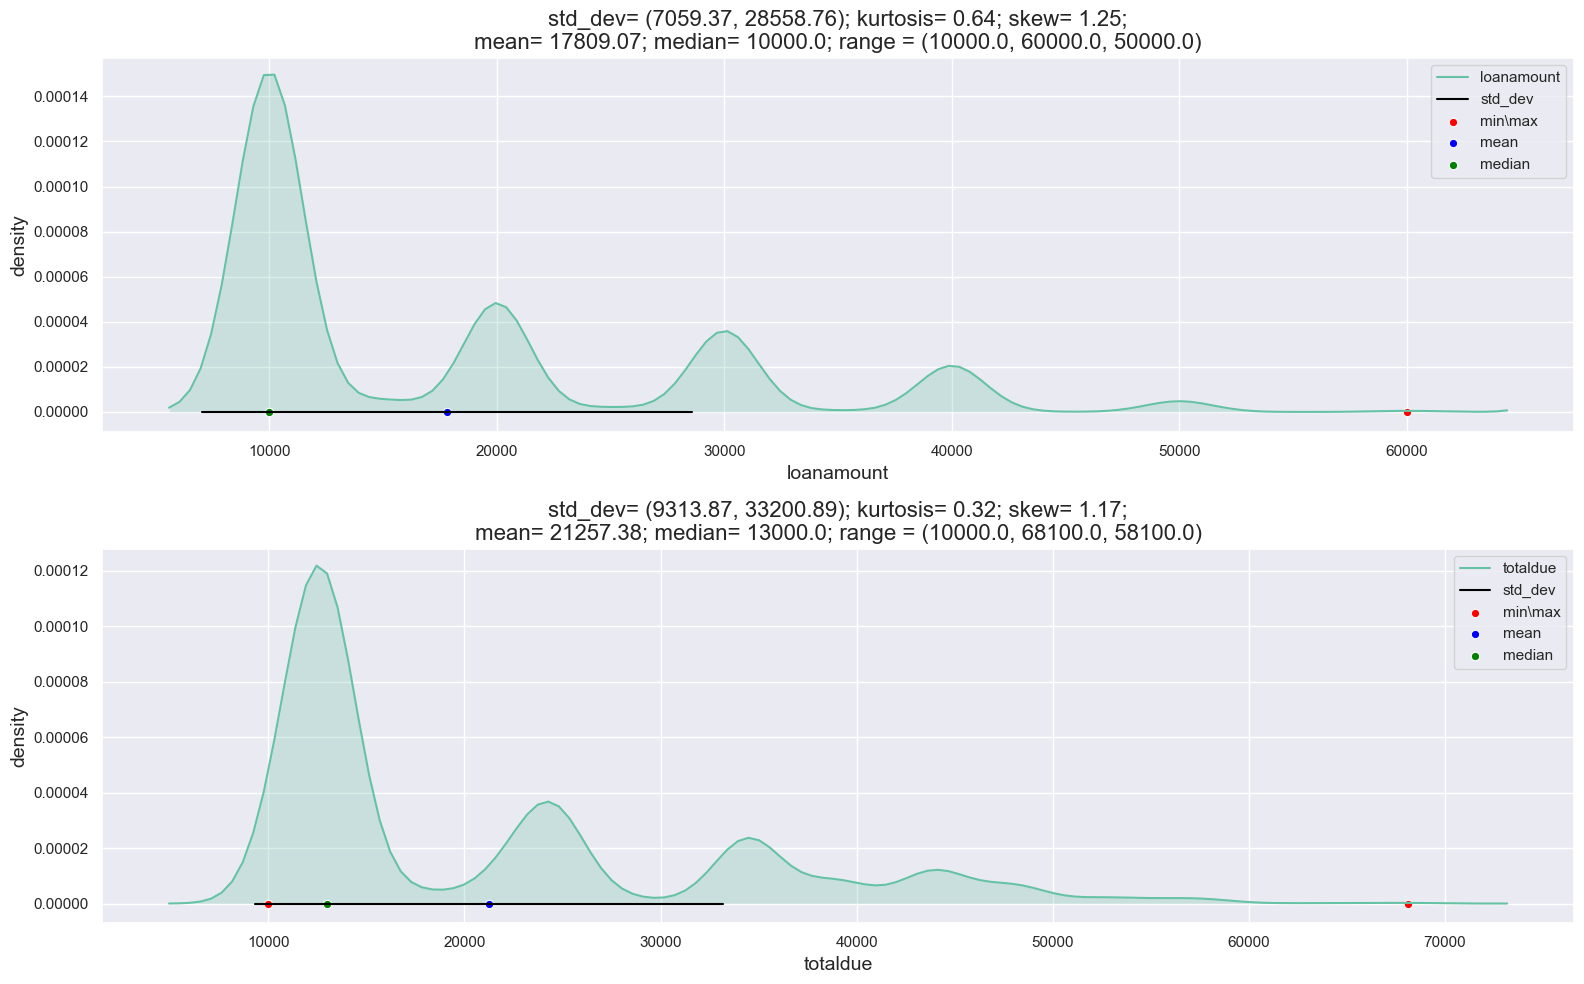

In [32]:
Kde_plot(data, ['loanamount','totaldue'])

**Observations:**
* Desprictive statistics and kde plot suggests both plots are not normally distrbuted (positivly skeewed).
* As expected, both loan amount and total dues follows the similar distribution.As, total due is just loan amount + interest and additional fees.
* Most loan amounts were for 10000 and most total dues is for 13000.
* Every customer have applied for apporximated loan amount.

**To check:** Does the additional charges(interest and addtional fees) have any trend?

In [33]:
print('Number of unique loan amounts:', data['loanamount'].nunique())
print('Unique loan amounts:', data['loanamount'].unique())

Number of unique loan amounts: 10
Unique loan amounts: [30000. 15000. 20000. 10000. 40000. 25000. 50000. 35000. 45000. 60000.]


**Note:** There are only 10 unique values for loan amounts that the customers had applied for.

**Creating new variable additional charges**

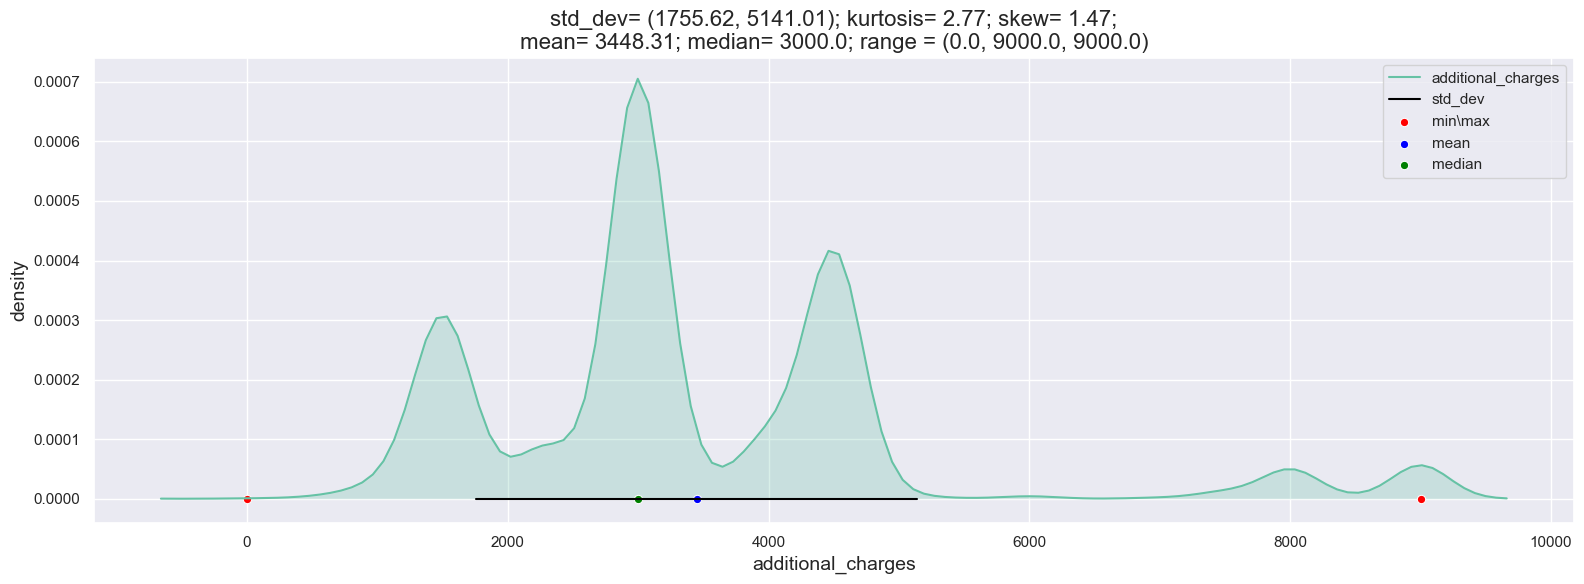

In [34]:
data['additional_charges'] = data['totaldue'] - data['loanamount']
Kde_plot(data,['additional_charges'])

**Observations:**
* There are few costumers who paid zero additional charges.
* Most customers paid 3000 as the the additional charges.
* From the graph we can also conclude for each customer addtional charges are different even they have applied for similar amount of loan.

**To check:** Relationship between additional charges and loan amount w.r.t target.
<br>
**Note:** Try to make new column interest rate.

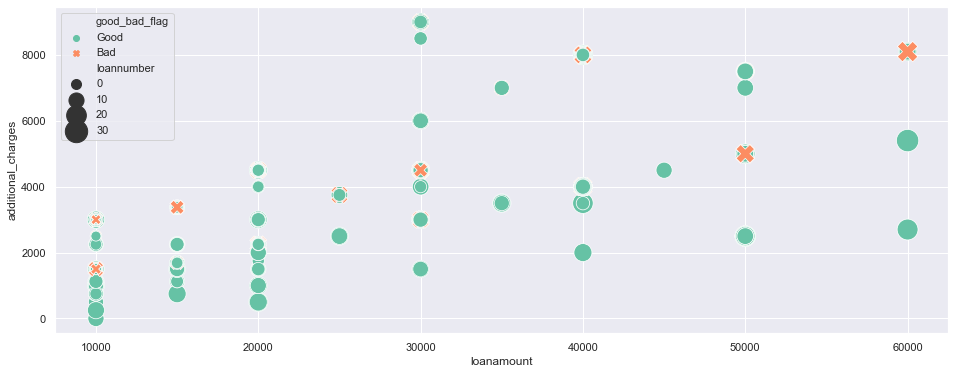

In [35]:
sns.scatterplot(data['loanamount'], data['additional_charges'],hue=data['good_bad_flag'],\
                style=data['good_bad_flag'],size=data['loannumber'],sizes=(100,500))

### termdays

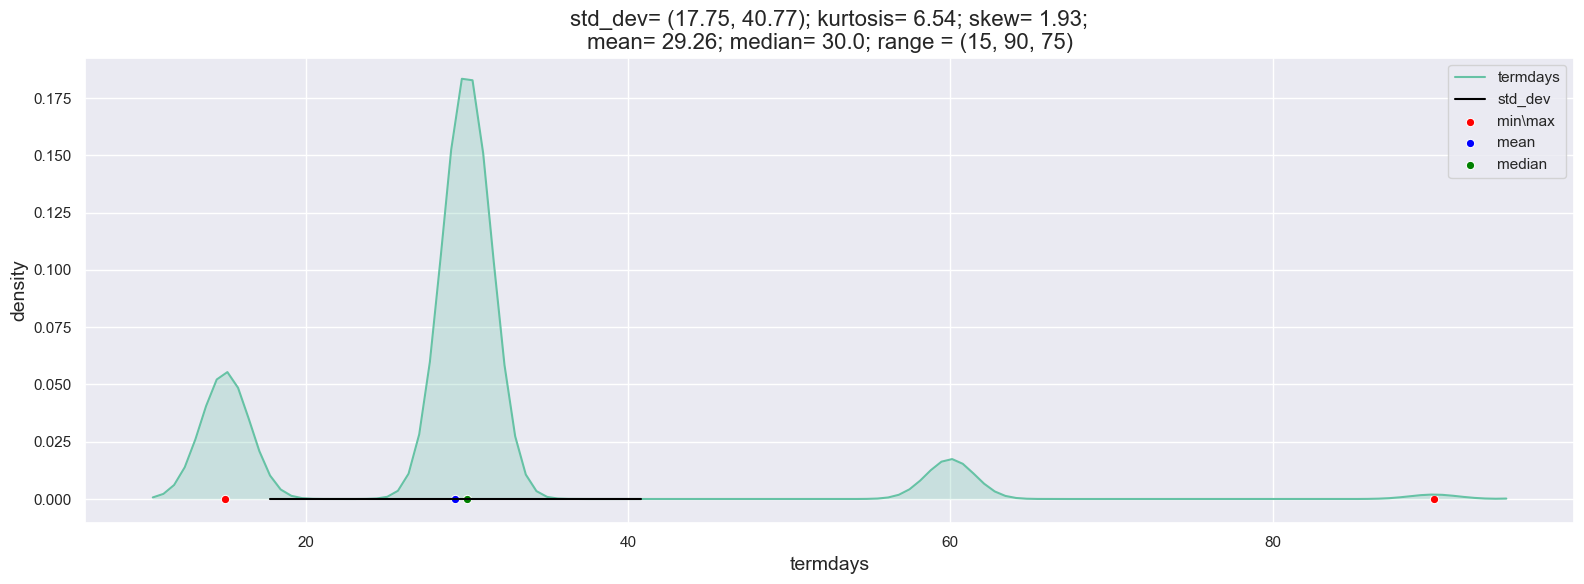

In [36]:
Kde_plot(data, ['termdays'], bw=1.5)

**Observations:**
* We can only see 4 peaks and a overall flat curve throughtout.
* Term days values ranges from 15 days to 90 days.
* Bar graph might show better results.


In [37]:
def Category_plot(column, data, rot=0):
    """
    Function to plot countplot and pie chart for categorical variables.
    
    """
    # Setting the figure size
    plt.figure(figsize=(10,4), dpi=150)
    
    
    # ploting the barplot
    plt.subplot(1,2,1)
    g=sns.countplot(x=column, data= data, palette='Set2')
    plt.title('Barplot for {}'.format(column), fontsize=14)
    plt.xticks(rotation=rot)
    plt.tight_layout()
    
    #ploting the pie chart 
    plt.subplot(1,2,2)
    plt.axis('equal')
    
    plt.pie(x= data[column].value_counts(), labels= data[column].value_counts().index, autopct='%0.1f%%', shadow=True)
    plt.title('Pie chart for {}'.format(column), fontsize=14)
    plt.tight_layout()
    plt.show()

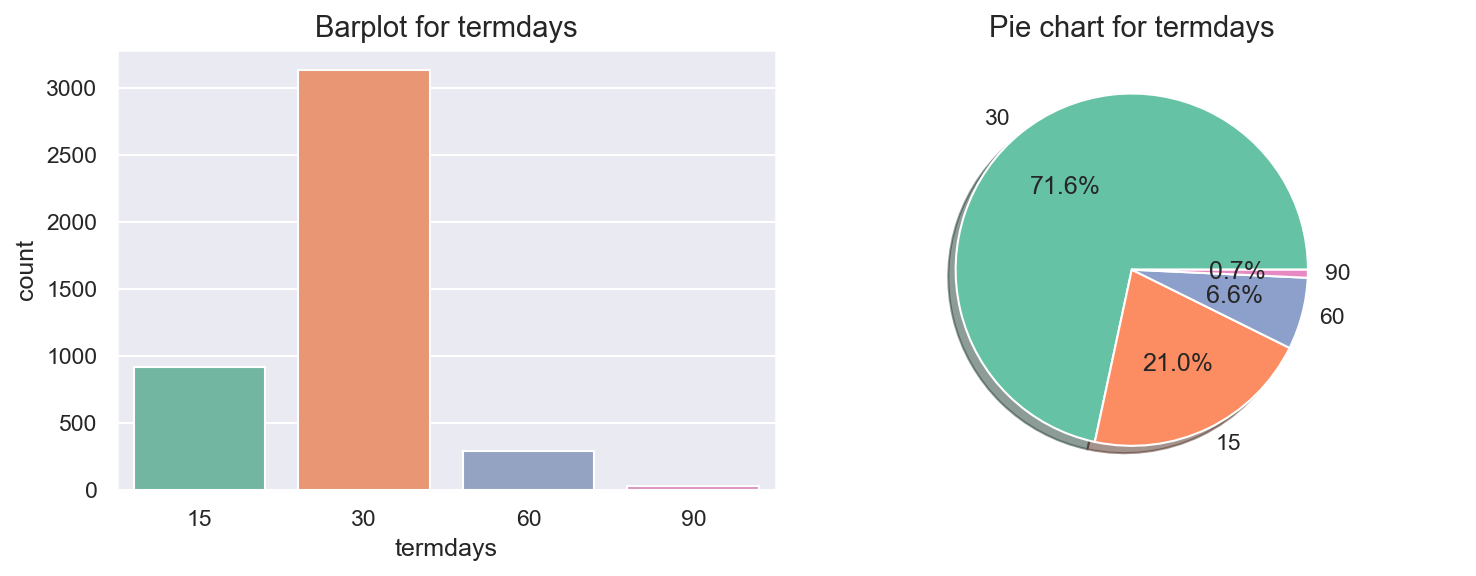

In [38]:
Category_plot('termdays', data)

**Observations:**
* Approximatly, 72% customers got 30 term days to return the loan amount(including additional charges).
* There are 7.2% of people who got 60 or more term days.

**To Check:** Do customers that got more term days have good flag?

In [ ]:
sns.scatterplot(data['termdays'], data['additional_charges'],hue=data['good_bad_flag'],\
                style=data['good_bad_flag'],size=data['loannumber'],sizes=(100,500))

### referredby

In [ ]:
data['referredby'].isnull().sum()/len(data['referredby'])*100

86 percent of the data is missing for this column. It will not a be useful even with we impute it using any of the methods.

**Creating new variable is_referred**

In [ ]:
data['referredby'].fillna(value='0',inplace=True)
data['is_referred'] = data['referredby'].apply(lambda x: 0 if x=='0' else 1)
data['is_referred'].value_counts()

In [ ]:
Category_plot('is_referred', data)

* 86% of people were not referred by anyone.
<br><br>
**To check:** Do people who are referred will have higher chances for paying loan back?

### birthdate

In [ ]:
#Converting birthdate to datetime 
data['birthdate'] = pd.to_datetime(data['birthdate'])

* Date variable will not be useful for our analysis.
<br>

**Creating new variable age from birthdate and creation date.**

In [ ]:
data['age'] = round((data['creationdate'] - data['birthdate']).dt.days/365.25)

In [ ]:
Kde_plot(data, ['age'])

**Observations:**
* The age distribution is close to a normal distribution with a little positive skeewness.
* Minimum and Maximum age for customers to have applied for loan is 21 and 56.
* Most of the customers have ages between 26 to 39 years.

**To check:** Which age group has the most number of customers that doesn't pay the loan amount?

### bank_account_type

In [ ]:
data['bank_account_type'].nunique()

* There are 3 unique categories for this variable.

In [ ]:
Category_plot('bank_account_type', data)

**Observations:** 
* Majority of the customers who applied for loan had saving account.
* Only 1.4% of customers who applied for loan has current account.

### longitude_gps and latitude_gps 

In [ ]:
Kde_plot(data, ['longitude_gps', 'latitude_gps'])

**Observations:**
* **longitude_gps:**
    * Value of kurtosis is very high, which signifies longitude_gps variable follows the leptokurtic distribution.
    * Skeewness is negative, data is little negativly skeewed.
    * Standard daviation is very low, which signifies most of the values lies in one standard daviation from the mean.
    * Mean and median are not very close signifies the distribution is not normally distributed.
    * Plot suggests the presence of extreme outliers on both tails.
* **latitude_gps:**
    * Value of kurtosis is very high, which signifies latitude_gps variable follows the leptokurtic distribution.
    * Skeewness is positive, data is little positivly skeewed.
    * Standard daviation is very low, which signifies most of the values lies in one standard daviation from the mean.
    * Mean and median are not very close signifies the distribution is not normally distributed.
    * Plot suggests the presence of extreme outliers on both tails.


### bank_name_clients

In [ ]:
data['bank_name_clients'].nunique()

* The present data is from 18 different banks. 

In [ ]:
Bar_plot(data, 'bank_name_clients', rotation=45)

**Obeservations:**
* Majority of the customers have their bank accounts in GT Bank.
* Number of customers for bank banks is farelly low. 

**To check:** Which bank tends to have least percent of customers that doesn't pay the loan back?

### bank_branch_clients

In [ ]:
data['bank_branch_clients'].nunique()

In [ ]:
data['bank_branch_clients'].isnull().sum()/len(data)*100

* 99% of data is missing for this variables. We should drop it for further analysis.

**Dropping bank branch clients**

In [ ]:
data.drop('bank_branch_clients', inplace=True, axis=1)

### employment_status_client

In [ ]:
data['employment_status_clients'].nunique()

In [ ]:
Category_plot('employment_status_clients', data, rot=45)

In [ ]:
data['employment_status_clients'] = data['employment_status_clients'].apply(lambda x: 'Permanent' if x == 'Permanent' else 'Others')
Category_plot('employment_status_clients', data)

**Observations:**
* Majority of the people who applied for loan have employment status as permanent.
* There are very few people who are unemployed but still the bank has given them loan.
* The maximum age for customer was 58 but still there are some people who are retired.

**To check:** Do unemployed customers pay back the loan on time?

### Level of education

In [ ]:
data['level_of_education_clients'].nunique()

In [ ]:
data['level_of_education_clients'].isnull().sum()/len(data)*100

* 90% of data is missing for the education level. Imputing missing values with any method won't give us useful outputs. So, we might drop this variable as well.

**Dropping Level of education**

In [ ]:
data.drop('level_of_education_clients', inplace=True, axis=1)

In [ ]:
data.isnull().sum()

### good_bad_flag (Target)

In [ ]:
data['good_bad_flag'].nunique()

As we already know through our problem statement that this is a binary classification supervised problem. So having only 2 unique values in our target variables makes sense.

In [ ]:
Category_plot('good_bad_flag', data)

**Observations:**
* There is a class imbalance for our target variable. 
* There are 78% good customers (returns the loan amount) and 22% bad customers (doesn't returns the loan amount). 

## Bivariate Analysis (Cont.-Cat)

### Function to perform statistical tests 

**Two sample z-test**

In [ ]:
# function to operate 2-sample z test
def TwoSampZ(X1, X2, sigma1, sigma2, N1, N2):
    
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    ovr_sigma = sqrt((sigma1**2/N1)+(sigma2**2/N2))
    z = (X1-X2)/ovr_sigma
    pval = 2*(1- norm.cdf(abs(z)))
    return pval

**Two sample t-test**

In [ ]:
# function to preform 2-sample t-test
def TwoSampT(x1, x2, sd1, sd2, n1, n2):
    
    from numpy import sqrt, abs, round
    from scipy.stats import t as t_dst
    over_sd = sqrt(((sd1**2/n1) + (sd2**2/n2)))
    t = (x1-x2)/over_sd
    df = n1+n2-2
    pval = 2*(1-t_dst.cdf(abs(t),df))
    return pval

**1-way anova**

In [ ]:
def One_way_anova(data, cont, cat):
    
    """
    Function that performs 1-way anova on a categorical variable to check wheather the mean between more than 2 groups is euqual
    and returns p-value 
    """

    #Creating a new dataframe with cont. and cat. var
    data_anova = data[[cat, cont]]
    
    #Overall mean of the variable
    overall_mean = data_anova[cont].mean()
    
    #Computing sum of square total
    data_anova['overall_mean'] = overall_mean
    ss_total = sum((data_anova[cont] - data_anova['overall_mean'])**2)
    
    #Computing group means
    group_means = pd.DataFrame(data_anova.groupby(cat).mean()[cont])\
                        .rename(columns={cont:'group_mean'})
    
    data_anova = data_anova.merge(group_means, left_on= cat, right_index=True)
    
    #Computing Sum of Square Residual
    ss_residual = sum((data_anova[cont] - data_anova['group_mean'])**2)
    
    #Computing Sum of Square Explained
    ss_explained = sum((data_anova['overall_mean'] - data_anova['group_mean'])**2)
    
    #Degree of freedom
    n_groups = data_anova[cat].nunique()
    n_obsev = data_anova.shape[0]
    df_residual = n_obsev-n_groups
    df_explained = n_groups-1
    
    #Computing Mean Squared Residual
    ms_residual = ss_residual/df_residual
    
    #Computing Mean Squared Explained 
    ms_explained = ss_explained/df_explained
    ms_explained
    
    #F-statistics
    f_statistics = ms_explained/ms_residual
    f_statistics
    
    #Computing p-value
    p_value = (1-scipy.stats.f.cdf(f_statistics, df_explained, df_residual))
    p_value
    
    return p_value

**Function to perform above tests on cont.-cat variables**

In [ ]:
def Bivariate_cont_cat(data, cont, cat, test=None, category=None):
  
    # For 2 sample t-test and z-test
    if test == 'z-t':
        x1 = data[cont][data[cat]==category][:]
        x2 = data[cont][~(data[cat]==category)][:]
      
        #calculating descriptives
        n1, n2 = x1.shape[0], x2.shape[0]
        m1, m2 = x1.mean(), x2.mean()
        std1, std2 = x1.std(), x2.std()
      
        #calculating p-values
        t_p_val = TwoSampT(m1, m2, std1, std2, n1, n2)
        z_p_val = TwoSampZ(m1, m2, std1, std2, n1, n2)
      
    
        #table
        table = pd.pivot_table(data=data, values=cont, columns=cat, aggfunc = np.mean)
    
        #plotting
        plt.figure(figsize = (15,6), dpi=140)
      
        #barplot
        plt.subplot(1,2,1)
        sns.barplot([str(category),'not {}'.format(category)], [m1, m2], palette='Set2')
        plt.ylabel('mean {}'.format(cont))
        plt.xlabel(cat)
        plt.title('t-test p-value = {} \n z-test p-value = {}\n {}'.format(t_p_val,
                                                                    z_p_val,
                                                                    table))
    
        # boxplot
        plt.subplot(1,2,2)
        sns.boxplot(x=cat, y=cont, data=data, palette='Set2')
        plt.title('categorical boxplot')
    
    # For 1-way anova
    elif test == 'anova':
        
        anova_p_value = One_way_anova(data, cont, cat)
        
        #table
        table = pd.pivot_table(data=data, values=cont, columns=cat, aggfunc = np.mean)
        
        # Setting the figure dimensions
        plt.figure(figsize=(16,6))
        
        #barplot
        plt.subplot(2,1,1)
        g = sns.barplot(data[cat], data[cont], ci=None, estimator=np.mean, palette='Set2')
        plt.title('\t1-way anova p-value = {}'.format(round(anova_p_value,8)), fontsize=14)
        plt.ylabel('Mean {}'.format(cont), fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlabel('{}'.format(cat), fontsize=14)
        
        for i in g.patches:
            g.annotate(s='{:.0f}'.format(i.get_height()), xy=(i.get_x()+0.3, i.get_height()+1))
        
        # boxplot
        plt.subplot(2,1,2)
        sns.boxplot(data[cat], data[cont], palette='Set2')
        plt.title(None)
        plt.ylabel('{}'.format(cont), fontsize=14)
        plt.xlabel('{}'.format(cat), fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        
    else:
        print('Wrong test chosen!!')


In [ ]:
Bivariate_cont_cat(data, 'totaldue', 'good_bad_flag', test='z-t')

In [ ]:
data.columns

## Previous Loan Data
In this segment we will analyse the prevoius loan data. The dataset contains the history of the customers when they applied for the loan earlier. So, we can try to find some usefull insights related to the customer behaviour for example do a unique customer paid the loan on time, what is the average loan amount any unique customer has taken till date, how frequently the customer takes loan from the bank etc. Later we can join these information with our primary dataset and use it for the modelling.

In [ ]:
ploan_data.head()

### approveddate and creationdate

**Converting to datetime format**

In [ ]:
ploan_data['approveddate'] = pd.to_datetime(ploan_data['approveddate'])
ploan_data['creationdate'] = pd.to_datetime(ploan_data['creationdate'])
ploan_data['closeddate'] = pd.to_datetime(ploan_data['closeddate'])
ploan_data['firstduedate'] = pd.to_datetime(ploan_data['firstduedate'])
ploan_data['firstrepaiddate'] = pd.to_datetime(ploan_data['firstrepaiddate'])

In [ ]:
for i in ['approveddate', 'creationdate']:
    print('Minimum date for {}: {}'.format(i, min(ploan_data[i])))
    print('Maximum date for {}: {}'.format(i, max(ploan_data[i])))

* The history of loan data is from 15-01-2016 to 28-01-2017 (approx. 1.5 years).
* There are some customers that took loan more than 15 times which simply means they are applying for mean every month.(Might need to look into details of these customers).

In [ ]:
ploan_data[ploan_data['loannumber']>10]['customerid'].nunique()

* There are 333 customers that had taken loan more than 10 times.

In [ ]:
ploan_data['customerid'].value_counts()

In [ ]:
ploan_data[ploan_data['customerid'] == '8a858f7d5578012a01557ea194d94948'].sort_values('loannumber')

**Creating new feature approval time**

In [ ]:
ploan_data['approval_time'] = round(((ploan_data['approveddate'] - ploan_data['creationdate']).dt.seconds)/3600,2)

In [ ]:
ploan_data.head()

In [ ]:
Kde_plot(ploan_data, ['approval_time'], bw=1.5)

In [ ]:
ploan_data[ploan_data['approval_time'] >20]

In [ ]:
ploan_data[ploan_data['customerid'] == '8a858eba5591bf2801559680580a1f9e'].sort_values('loannumber').head(10)

In [ ]:
ploan_data[ploan_data['customerid'] == '8a858e8d56b784480156bc6edb9004d9'].sort_values('loannumber').head(5)

**Creating new feature return_days**

In [ ]:
ploan_data['return_days'] = (ploan_data['closeddate'] - ploan_data['approveddate']).dt.days

In [ ]:
Kde_plot(ploan_data, ['return_days'])

**Observations:**
* Many people returned the loan amount on the same date.
* Some people took more than 3 months to return the loan amount.
* Most of the people returned the loan amount within 10 to 35 days.

In [ ]:
ploan_data[ploan_data['return_days'] ==0]['return_days'].count()

**Creating new feature first_return_days**

In [ ]:
ploan_data['first_return_days'] = (ploan_data['firstduedate'] - ploan_data['firstrepaiddate']).dt.days

In [ ]:
Kde_plot(ploan_data, ['first_return_days'])

**Creating new feature repaid_on_time**

In [ ]:
ploan_data['repaid_on_time'] = ploan_data['first_return_days'].apply(lambda x: 1 if x >= 0 else 0)

In [ ]:
Category_plot('repaid_on_time', ploan_data)

**Observations:**
* 35% of times customers had paid the loan amount late.

#### New variable not_repaid percentage

In [ ]:
new = pd.crosstab(ploan_data['customerid'], ploan_data['repaid_on_time']).reset_index()
new['not_repaid_percentage'] = new.apply(lambda x: round((x[1]/(x[0]+x[1]))*100), axis=1)

**Creating new feature additional charges**

In [ ]:
ploan_data['additional charges'] = ploan_data['totaldue'] - ploan_data['loanamount']

In [ ]:
Kde_plot(ploan_data, ['additional charges'])

In [ ]:
ploan_data.columns

In [ ]:
column = ['loanamount', 'totaldue', 'termdays','approval_time',
          'return_days', 'first_return_days','additional charges', 'additional charges']

uni_cust_ploan_data = ploan_data['customerid'].value_counts().reset_index().rename(columns={'index':'customerid','customerid':'count'})

for i in column:
    des_col = {'mean': 'ploan_'+i+'_mean', 'min': 'ploan_'+i+'_min', '25%': 'ploan_'+i+'_25%', '50%': 'ploan_'+i+'_50%', '75%': 'ploan_'+i+'_75%', 'max':'ploan_'+i+'_max'}
    describe_data = ploan_data.groupby(by='customerid')[i].describe()[['mean','min','25%','50%','75%','max']].reset_index().rename(columns=des_col)
    uni_cust_ploan_data = uni_cust_ploan_data.merge(right=describe_data, how='left', on='customerid', copy=False)

In [ ]:
uni_cust_ploan_data.head()

In [ ]:
uni_cust_ploan_data.drop('count', axis=1, inplace=True)

In [ ]:
uni_cust_ploan_data = uni_cust_ploan_data.merge(new[['customerid', 'not_repaid_percentage']], on='customerid', how='inner', copy=False)

In [ ]:
uni_cust_ploan_data.shape

In [ ]:
data_com  = data.merge(uni_cust_ploan_data, how='left', on='customerid', copy=False)

In [ ]:
data_com.head()

In [ ]:
column = ['ploan_loanamount_mean', 'ploan_loanamount_min',
       'ploan_loanamount_25%', 'ploan_loanamount_50%', 'ploan_loanamount_75%',
       'ploan_loanamount_max', 'ploan_totaldue_mean', 'ploan_totaldue_min',
       'ploan_totaldue_25%', 'ploan_totaldue_50%', 'ploan_totaldue_75%',
       'ploan_totaldue_max', 'ploan_termdays_mean', 'ploan_termdays_min',
       'ploan_termdays_25%', 'ploan_termdays_50%', 'ploan_termdays_75%',
       'ploan_termdays_max', 'ploan_approval_time_mean',
       'ploan_approval_time_min', 'ploan_approval_time_25%',
       'ploan_approval_time_50%', 'ploan_approval_time_75%',
       'ploan_approval_time_max', 'ploan_return_days_mean',
       'ploan_return_days_min', 'ploan_return_days_25%',
       'ploan_return_days_50%', 'ploan_return_days_75%',
       'ploan_return_days_max', 'ploan_first_return_days_mean',
       'ploan_first_return_days_min', 'ploan_first_return_days_25%',
       'ploan_first_return_days_50%', 'ploan_first_return_days_75%',
       'ploan_first_return_days_max', 'ploan_additional charges_mean_x',
       'ploan_additional charges_min_x', 'ploan_additional charges_25%_x',
       'ploan_additional charges_50%_x', 'ploan_additional charges_75%_x',
       'ploan_additional charges_max_x', 'ploan_additional charges_mean_y',
       'ploan_additional charges_min_y', 'ploan_additional charges_25%_y',
       'ploan_additional charges_50%_y', 'ploan_additional charges_75%_y',
       'ploan_additional charges_max_y', 'not_repaid_percentage']

### Imputing Missing Values

In [ ]:
for i in column:
    data_com[i].fillna(data_com[i].mean(), inplace=True)

In [ ]:
data_com.drop(['birthdate','approveddate','creationdate','customerid', 'systemloanid', 'referredby'], axis=1, inplace=True)

In [ ]:
data_com.to_csv('Loan data cleaned.csv', index=False)

In [ ]:
data['good_bad_flag'].value_counts()/len(data)*100

## Modeling:

In [ ]:
x = data_com.drop(['birthdate','approveddate','creationdate','customerid', 'systemloanid', 'referredby','good_bad_flag'], axis=1)
y = data_com['good_bad_flag'].replace({'Good':0, 'Bad':1})

In [ ]:
x = pd.get_dummies(data=x, columns=['creationdate_dow','bank_account_type', 'bank_name_clients', 'employment_status_clients'], drop_first=True)

### Data Transformation

In [ ]:
num_var = ['loanamount', 'totaldue', 'longitude_gps',
       'latitude_gps', 'approval_time', 'additional_charges', 'age', 
        'ploan_loanamount_mean', 'ploan_loanamount_min',
       'ploan_loanamount_25%', 'ploan_loanamount_50%', 'ploan_loanamount_75%',
       'ploan_loanamount_max', 'ploan_totaldue_mean', 'ploan_totaldue_min',
       'ploan_totaldue_25%', 'ploan_totaldue_50%', 'ploan_totaldue_75%',
       'ploan_totaldue_max', 'ploan_termdays_mean', 'ploan_termdays_min',
       'ploan_termdays_25%', 'ploan_termdays_50%', 'ploan_termdays_75%',
       'ploan_termdays_max', 'ploan_approval_time_mean',
       'ploan_approval_time_min', 'ploan_approval_time_25%',
       'ploan_approval_time_50%', 'ploan_approval_time_75%',
       'ploan_approval_time_max', 'ploan_return_time_mean',
       'ploan_return_time_min', 'ploan_return_time_25%',
       'ploan_return_time_50%', 'ploan_return_time_75%',
       'ploan_return_time_max', 'ploan_return_days_mean',
       'ploan_return_days_min', 'ploan_return_days_25%',
       'ploan_return_days_50%', 'ploan_return_days_75%',
       'ploan_return_days_max', 'ploan_first_return_days_mean',
       'ploan_first_return_days_min', 'ploan_first_return_days_25%',
       'ploan_first_return_days_50%', 'ploan_first_return_days_75%',
       'ploan_first_return_days_max', 'ploan_additional charges_mean',
       'ploan_additional charges_min', 'ploan_additional charges_25%',
       'ploan_additional charges_50%', 'ploan_additional charges_75%',
       'ploan_additional charges_max']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=101, test_size=0.2, stratify=y)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled, columns=x_train.columns)

x_test_scaled = scaler.transform(x_test)
x_test = pd.DataFrame(x_test_scaled, columns=x_test.columns)

In [ ]:
logreg = LogisticRegression(class_weight= 'balanced')
logreg.fit(x_train, y_train)
train_pred = logreg.predict(x_train)
test_pred = logreg.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(train_pred, y_train))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_pred, y_test))

In [ ]:
confusion_matrix(test_pred, y_test)

In [ ]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = x.columns
c = logreg.coef_.reshape(-1)
plt.bar( x, c )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Coefficient plot')
plt.xticks(rotation = 90)
plt.show()

## KNN model

In [ ]:
# Function to perform knn 
from sklearn.neighbors import KNeighborsClassifier

def Knn_Class(x_train, y_train, x_test, y_test, k_range, weight='uniform', p=2):
    
    # List to store f1 scores for train and test 
    f1_train = []
    f1_test = []
    
    for k in k_range:
        
        #Setting up the model parametes
        knn = KNeighborsClassifier(weights=weight, n_neighbors=k, n_jobs=-1, p=p)
        
        #Fitting model on training data
        knn.fit(x_train, y_train)
        
        #predicting on train and test 
        train_pred = knn.predict(x_train)
        test_pred = knn.predict(x_test)
        
        #Calculating error
        train_score = f1_score(train_pred, y_train)
        f1_train.append(train_score)
        
        test_score = f1_score(test_pred, y_test)
        f1_test.append(test_score)
    
    # Ploting for f1_scores 
    plt.plot(k_range,f1_train, label='Training Score')
    plt.plot(k_range,f1_test, label='Testing Score')
    plt.legend()

In [ ]:
# Predicting f1 score for different values of k 
Knn_Class(x_train, y_train, x_test, y_test, range(1,20))

In [ ]:
x = data_com.drop('good_bad_flag', axis=1)
y = data_com['good_bad_flag'].replace({'Good':0, 'Bad':1})

In [ ]:
data_com.shape

In [ ]:
# Divinding the data to train and test 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101, stratify=y)

x_train = pd.get_dummies(data=x_train, columns=['creationdate_dow','bank_account_type', 'bank_name_clients', 'employment_status_clients'], drop_first=True)
x_test = pd.get_dummies(data=x_test, columns=['creationdate_dow','bank_account_type', 'bank_name_clients', 'employment_status_clients'], drop_first=True)

In [ ]:
from sklearn.model_selection import cross_val_score

def Knn_cross_val(x_train, y_train, k_range, weight='uniform', p=2, cv=5):
    
    # List to store f1 scores for train and test 
    f1_val = []
    f1_std = []
    
    for k in k_range:
        
        #Setting up the model parametes
        knn = KNeighborsClassifier(weights=weight, n_neighbors=k, n_jobs=-1, p=p)
        
        #Fitting model on training data
        score = cross_val_score(knn, X= x_train, y= y_train, cv=cv, scoring='f1')
        
        f1_val.append(score.mean())
        f1_std.append(score.std())
        
    # Ploting for f1_scores 
    plt.subplot(2,1,1)
    plt.plot(k_range,f1_val, label='Validation Score')
    
    plt.subplot(2,1,2)
    plt.plot(k_range, f1_std, label='Std of validation', color='red')

In [ ]:
Knn_cross_val(x_train, y_train, range(1,50))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
pred = knn.predict(x_test)
score = f1_score(pred, y_test)

In [ ]:
score

### Forward Feature Selection with k=3

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
sfs1 = sfs(estimator= knn,k_features=20, scoring='f1', verbose=1, n_jobs=-1)
sfs1.fit(x_train, y_train)

In [ ]:
feat_names = list(sfs1.k_feature_names_)
feat_names

In [ ]:
x_train_selected = x_train[feat_names]
x_test_selected = x_test[feat_names]

In [ ]:
Knn_cross_val(x_train_selected, y_train, k_range=range(1,50))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_selected, y_train)

pred_train = knn.predict(x_train_selected)
pred_test = knn.predict(x_test_selected)

score_train = f1_score(pred_train, y_train)
score_test = f1_score(pred_test, y_test)
print(score_train,'\n',score_test)


We are getting better scores on training data but bad results on our testing data. The model is ovefitting.